In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle
import warnings

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column, vstack, join

import numpy as np 

import matplotlib.pyplot as plt
from matplotlib import rcParams

from dsigma.jackknife import add_continous_fields
from dsigma.jackknife import jackknife_resampling
from dsigma.jackknife import jackknife_field_centers, add_jackknife_fields

In [3]:
import jianbing

from jianbing import visual
from jianbing import prepare
from jianbing import catalog
from jianbing import scatter
from jianbing import wlensing

In [5]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

In [7]:
des_dir = os.path.join(jianbing.JB_DIR, 'data', 'des')

### HSC lensing pre-compute

#### DES lensing results from Chang et al. (2018)

In [4]:
topn_dir = "/Volumes/astro1/hsc/topn"

# Lensing data using medium photo-z quality cut
lensing = os.path.join(topn_dir, 'prepare', 's16a_weak_lensing_medium_comoving.hdf5')

# Random
rand = Table.read(lensing, path='random')

# Pre-compute
precompute = os.path.join(topn_dir, 'precompute', 's16a_weak_lensing_medium_comoving_precompute.hdf5')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/astro1/hsc/topn/prepare/s16a_weak_lensing_medium_comoving.hdf5'

In [5]:
redm_sdss = Table.read(precompute, path='redm_sdss_specz')

redm_hsc = Table.read(precompute, path='redm_hsc_specz')

In [8]:
# DES fiducial profile: 20 < lambda < 100; 0.2 < z < 0.55
# From Chang et al. 2018 (Fig 3)
# h=0.7; comoving; median z = 0.41
# R_comoving = (1+z) * R_physical

des_dsig = Table.read(os.path.join(des_dir, 'y1_DeltaSigma_metacal_unblind.txt'), format='ascii')

In [13]:
mask_sdss = (
    (redm_sdss['z'] >= 0.2) & (redm_sdss['z'] <= 0.55) &
    (redm_sdss['lambda_cluster_redm'] >= 20)
)

print(mask_sdss.sum())

dsig_sdss = wlensing.batch_dsigma_profiles(
    redm_sdss, rand, [mask_sdss], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

480


In [46]:
mask_hsc = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.55) &
    (redm_hsc['lambda'] >= 20)
)

print(mask_hsc.sum())

dsig_hsc = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_hsc], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

285
There are 285 objects in sample 1


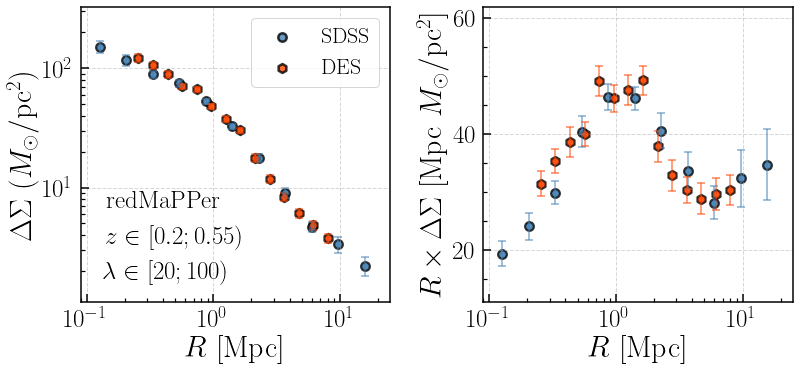

In [50]:
fig = plt.figure(figsize=(11.5, 5))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

ax1 = fig.add_subplot(121)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_sdss.meta['r_mpc'], dsig_sdss[0]['dsigma'], yerr=dsig_sdss[0]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax1.scatter(
    dsig_sdss.meta['r_mpc'], dsig_sdss[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm SDSS$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_dsig['col1'],  des_dsig['col2'], yerr= des_dsig['col3'],
             ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax1.scatter(
    des_dsig['col1'] , des_dsig['col2'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.09, 25)
_ = ax1.set_ylim(1.1, 329)

ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.55)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [20; 100)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(122)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_sdss.meta['r_mpc'], dsig_sdss.meta['r_mpc'] * dsig_sdss[0]['dsigma'], 
    yerr=(dsig_sdss.meta['r_mpc'] * dsig_sdss[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_sdss.meta['r_mpc'], dsig_sdss.meta['r_mpc'] * dsig_sdss[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_dsig['col1'],  des_dsig['col1'] * des_dsig['col2'], 
    yerr=(des_dsig['col1'] * des_dsig['col3']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_dsig['col1'] , des_dsig['col1'] * des_dsig['col2'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.09, 25)
_ = ax2.set_ylim(11, 62)

_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=30)

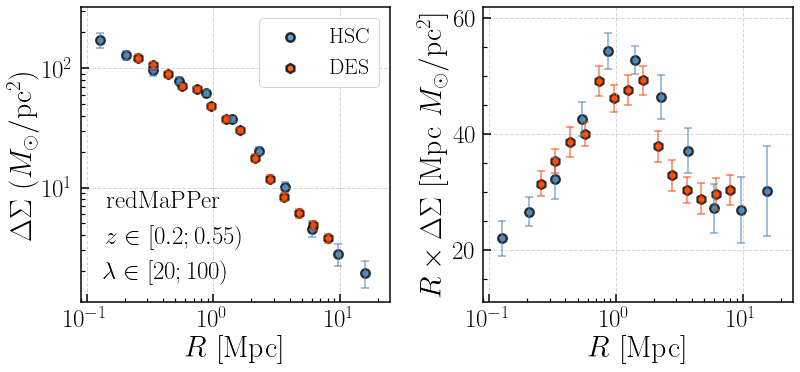

In [51]:
fig = plt.figure(figsize=(11.5, 5))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

ax1 = fig.add_subplot(121)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_hsc.meta['r_mpc'], dsig_hsc[0]['dsigma'], yerr=dsig_hsc[0]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax1.scatter(
    dsig_hsc.meta['r_mpc'], dsig_hsc[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_dsig['col1'],  des_dsig['col2'], yerr= des_dsig['col3'],
             ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax1.scatter(
    des_dsig['col1'] , des_dsig['col2'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.09, 25)
_ = ax1.set_ylim(1.1, 329)

ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.55)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [20; 100)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(122)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc.meta['r_mpc'], dsig_hsc.meta['r_mpc'] * dsig_hsc[0]['dsigma'], 
    yerr=(dsig_hsc.meta['r_mpc'] * dsig_hsc[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_hsc.meta['r_mpc'], dsig_hsc.meta['r_mpc'] * dsig_hsc[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_dsig['col1'],  des_dsig['col1'] * des_dsig['col2'], 
    yerr=(des_dsig['col1'] * des_dsig['col3']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_dsig['col1'] , des_dsig['col1'] * des_dsig['col2'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.09, 25)
_ = ax2.set_ylim(11, 62)

_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=30)

#### DES lensing from McClintock et al. (2018)

In [7]:
# Lensing data using medium photo-z quality cut
lensing = os.path.join(topn_dir, 'prepare', 's16a_weak_lensing_medium_larger.hdf5')

# Random
rand = Table.read(lensing, path='random')

# Pre-compute
precompute = os.path.join(topn_dir, 'precompute', 's16a_weak_lensing_medium_larger_precompute.hdf5')

redm_sdss = Table.read(precompute, path='redm_sdss_specz')

redm_hsc = Table.read(precompute, path='redm_hsc_specz')

##### 5 < lambda < 10

In [12]:
des_dir = '../../data/dsigma/des/'

des_1 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l0_z0_profile.dat'), format='ascii')
des_2 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l0_z1_profile.dat'), format='ascii')

In [14]:
mask_1 = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.35) &
    (redm_hsc['lambda'] >= 5) & (redm_hsc['lambda'] < 10)
)

mask_2 = (
    (redm_hsc['z'] >= 0.35) & (redm_hsc['z'] <= 0.5) &
    (redm_hsc['lambda'] >= 5) & (redm_hsc['lambda'] < 10)
)

print(mask_1.sum(), mask_2.sum())

dsig_hsc_0 = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_1, mask_2], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

624 1048
There are 624 objects in sample 1
There are 1048 objects in sample 2


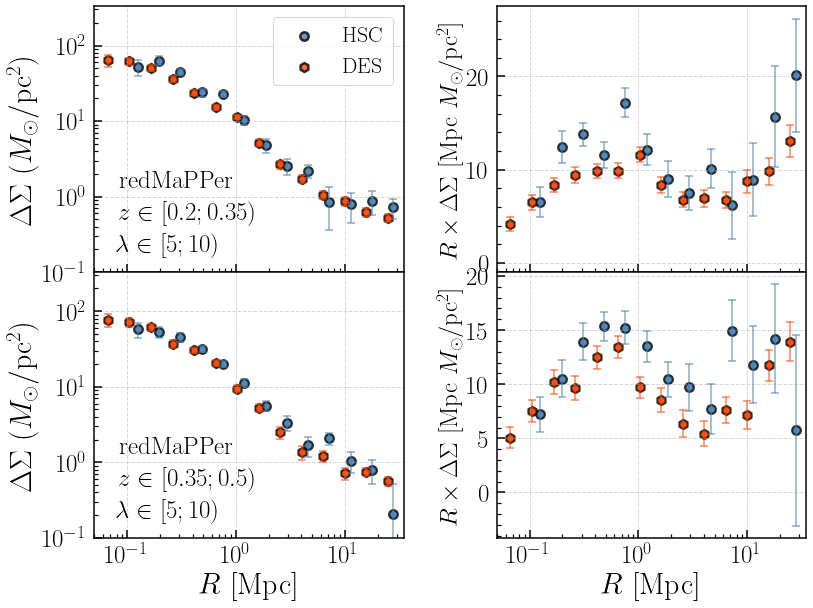

In [19]:
fig = plt.figure(figsize=(11.5, 9))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

# ---------------------------------------------------------------------- #
# 0.2 < z < 0.35
ax1 = fig.add_subplot(221)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0[0]['dsigma'], yerr=dsig_hsc_0[0]['dsig_err_jk'],
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_1['r_mpc'], des_1['dsigma'], yerr=des_1['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    des_1['r_mpc'] , des_1['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.05, 35)
_ = ax1.set_ylim(0.1, 329)

#ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.35)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [5; 10)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(222)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0.meta['r_mpc'] * dsig_hsc_0[0]['dsigma'], 
    yerr=(dsig_hsc_0.meta['r_mpc'] * dsig_hsc_0[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0.meta['r_mpc'] * dsig_hsc_0[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_1['r_mpc'], des_1['r_mpc'] * des_1['dsigma'], 
    yerr=(des_1['r_mpc'] * des_1['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_1['r_mpc'] , des_1['r_mpc'] * des_1['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.05, 35)
#_ = ax2.set_ylim(11, 62)

#_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

# ---------------------------------------------------------------------- #
# 0.35 < z < 0.5
ax3 = fig.add_subplot(223)
ax3.set_xscale("log", nonpositive='clip')
ax3.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax3.errorbar(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0[1]['dsigma'], yerr=dsig_hsc_0[1]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax3.scatter(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax3.errorbar(
    des_2['r_mpc'], des_2['dsigma'], yerr=des_2['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax3.scatter(
    des_2['r_mpc'] , des_2['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

#ax3.legend(loc='best', fontsize=22)

_ = ax3.set_xlim(0.05, 35)
_ = ax3.set_ylim(0.1, 329)

ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax3.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax3.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.08, 0.20, r'$z\in [0.35; 0.5)$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.07, 0.08, r'$\lambda \in [5; 10)$', transform=ax3.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax4 = fig.add_subplot(224)
ax4.set_xscale("log", nonpositive='clip')

# HSC profile
ax4.errorbar(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0.meta['r_mpc'] * dsig_hsc_0[1]['dsigma'], 
    yerr=(dsig_hsc_0.meta['r_mpc'] * dsig_hsc_0[1]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    dsig_hsc_0.meta['r_mpc'], dsig_hsc_0.meta['r_mpc'] * dsig_hsc_0[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax4.errorbar(
    des_2['r_mpc'], des_2['r_mpc'] * des_2['dsigma'], 
    yerr=(des_2['r_mpc'] * des_2['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    des_2['r_mpc'] , des_2['r_mpc'] * des_2['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax4.set_xlim(0.05, 35)
#_ = ax4.set_ylim(11, 62)

_ = ax4.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax4.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

##### 10 < lambda < 14

In [31]:
des_dir = '../../data/dsigma/des/'

des_1 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l1_z0_profile.dat'), format='ascii')
des_2 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l1_z1_profile.dat'), format='ascii')

In [32]:
mask_1 = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.35) &
    (redm_hsc['lambda'] >= 10) & (redm_hsc['lambda'] < 14)
)

mask_2 = (
    (redm_hsc['z'] >= 0.35) & (redm_hsc['z'] <= 0.5) &
    (redm_hsc['lambda'] >= 10) & (redm_hsc['lambda'] < 14)
)

print(mask_1.sum(), mask_2.sum())

dsig_hsc_1 = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_1, mask_2], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

146 212
There are 146 objects in sample 1
There are 212 objects in sample 2


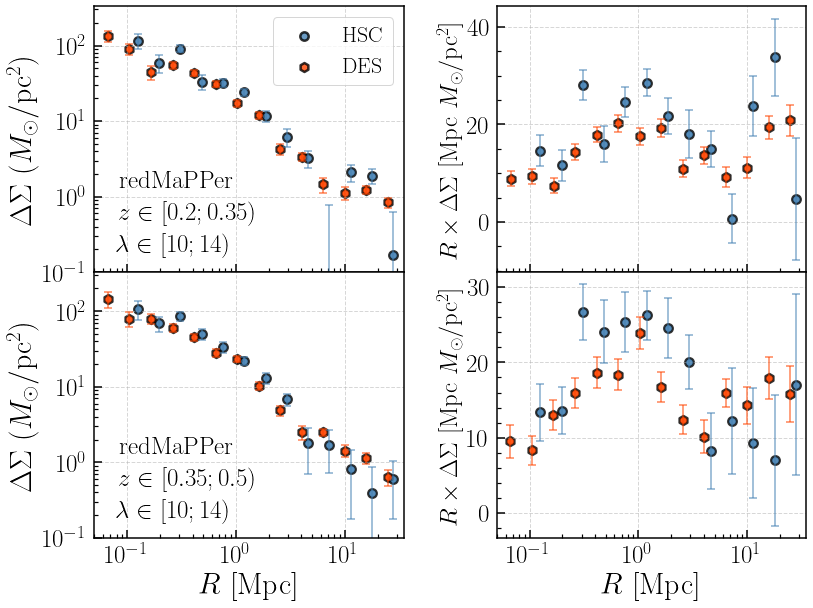

In [34]:
fig = plt.figure(figsize=(11.5, 9))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

# ---------------------------------------------------------------------- #
# 0.2 < z < 0.35
ax1 = fig.add_subplot(221)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1[0]['dsigma'], yerr=dsig_hsc_1[0]['dsig_err_jk'],
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_1['r_mpc'], des_1['dsigma'], yerr=des_1['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    des_1['r_mpc'] , des_1['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.05, 35)
_ = ax1.set_ylim(0.1, 329)

#ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.35)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [10; 14)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(222)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1.meta['r_mpc'] * dsig_hsc_1[0]['dsigma'], 
    yerr=(dsig_hsc_1.meta['r_mpc'] * dsig_hsc_1[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1.meta['r_mpc'] * dsig_hsc_1[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_1['r_mpc'], des_1['r_mpc'] * des_1['dsigma'], 
    yerr=(des_1['r_mpc'] * des_1['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_1['r_mpc'] , des_1['r_mpc'] * des_1['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.05, 35)
#_ = ax2.set_ylim(11, 62)

#_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

# ---------------------------------------------------------------------- #
# 0.35 < z < 0.5
ax3 = fig.add_subplot(223)
ax3.set_xscale("log", nonpositive='clip')
ax3.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax3.errorbar(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1[1]['dsigma'], yerr=dsig_hsc_1[1]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax3.scatter(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax3.errorbar(
    des_2['r_mpc'], des_2['dsigma'], yerr=des_2['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax3.scatter(
    des_2['r_mpc'] , des_2['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

#ax3.legend(loc='best', fontsize=22)

_ = ax3.set_xlim(0.05, 35)
_ = ax3.set_ylim(0.1, 329)

ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax3.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax3.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.08, 0.20, r'$z\in [0.35; 0.5)$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.07, 0.08, r'$\lambda \in [10; 14)$', transform=ax3.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax4 = fig.add_subplot(224)
ax4.set_xscale("log", nonpositive='clip')

# HSC profile
ax4.errorbar(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1.meta['r_mpc'] * dsig_hsc_1[1]['dsigma'], 
    yerr=(dsig_hsc_1.meta['r_mpc'] * dsig_hsc_1[1]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    dsig_hsc_1.meta['r_mpc'], dsig_hsc_1.meta['r_mpc'] * dsig_hsc_1[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax4.errorbar(
    des_2['r_mpc'], des_2['r_mpc'] * des_2['dsigma'], 
    yerr=(des_2['r_mpc'] * des_2['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    des_2['r_mpc'] , des_2['r_mpc'] * des_2['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax4.set_xlim(0.05, 35)
#_ = ax4.set_ylim(11, 62)

_ = ax4.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax4.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

##### 14 < lambda < 20

In [35]:
des_1 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l2_z0_profile.dat'), format='ascii')
des_2 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l2_z1_profile.dat'), format='ascii')

In [36]:
mask_1 = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.35) &
    (redm_hsc['lambda'] >= 14) & (redm_hsc['lambda'] < 20)
)

mask_2 = (
    (redm_hsc['z'] >= 0.35) & (redm_hsc['z'] <= 0.5) &
    (redm_hsc['lambda'] >= 14) & (redm_hsc['lambda'] < 20)
)

print(mask_1.sum(), mask_2.sum())

dsig_hsc_2 = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_1, mask_2], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

91 144
There are 91 objects in sample 1
There are 144 objects in sample 2


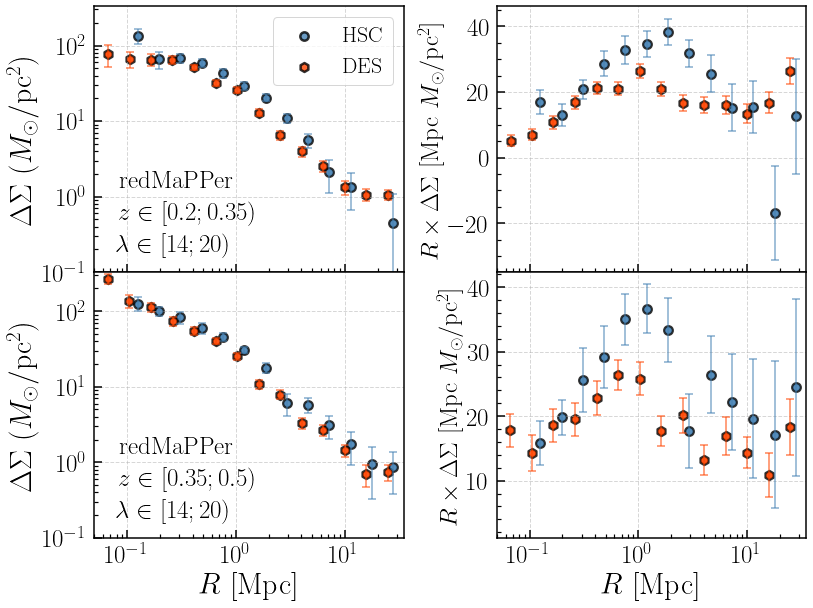

In [37]:
fig = plt.figure(figsize=(11.5, 9))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

# ---------------------------------------------------------------------- #
# 0.2 < z < 0.35
ax1 = fig.add_subplot(221)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2[0]['dsigma'], yerr=dsig_hsc_2[0]['dsig_err_jk'],
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_1['r_mpc'], des_1['dsigma'], yerr=des_1['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    des_1['r_mpc'] , des_1['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.05, 35)
_ = ax1.set_ylim(0.1, 329)

#ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.35)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [14; 20)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(222)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2.meta['r_mpc'] * dsig_hsc_2[0]['dsigma'], 
    yerr=(dsig_hsc_2.meta['r_mpc'] * dsig_hsc_2[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2.meta['r_mpc'] * dsig_hsc_2[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_1['r_mpc'], des_1['r_mpc'] * des_1['dsigma'], 
    yerr=(des_1['r_mpc'] * des_1['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_1['r_mpc'] , des_1['r_mpc'] * des_1['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.05, 35)
#_ = ax2.set_ylim(11, 62)

#_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

# ---------------------------------------------------------------------- #
# 0.35 < z < 0.5
ax3 = fig.add_subplot(223)
ax3.set_xscale("log", nonpositive='clip')
ax3.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax3.errorbar(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2[1]['dsigma'], yerr=dsig_hsc_2[1]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax3.scatter(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax3.errorbar(
    des_2['r_mpc'], des_2['dsigma'], yerr=des_2['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax3.scatter(
    des_2['r_mpc'] , des_2['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

#ax3.legend(loc='best', fontsize=22)

_ = ax3.set_xlim(0.05, 35)
_ = ax3.set_ylim(0.1, 329)

ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax3.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax3.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.08, 0.20, r'$z\in [0.35; 0.5)$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.07, 0.08, r'$\lambda \in [14; 20)$', transform=ax3.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax4 = fig.add_subplot(224)
ax4.set_xscale("log", nonpositive='clip')

# HSC profile
ax4.errorbar(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2.meta['r_mpc'] * dsig_hsc_2[1]['dsigma'], 
    yerr=(dsig_hsc_2.meta['r_mpc'] * dsig_hsc_2[1]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    dsig_hsc_2.meta['r_mpc'], dsig_hsc_2.meta['r_mpc'] * dsig_hsc_2[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax4.errorbar(
    des_2['r_mpc'], des_2['r_mpc'] * des_2['dsigma'], 
    yerr=(des_2['r_mpc'] * des_2['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    des_2['r_mpc'] , des_2['r_mpc'] * des_2['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax4.set_xlim(0.05, 35)
#_ = ax4.set_ylim(11, 62)

_ = ax4.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax4.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

##### 20 < lambda < 30

In [38]:
des_1 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l3_z0_profile.dat'), format='ascii')
des_2 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l3_z1_profile.dat'), format='ascii')

In [39]:
mask_1 = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.35) &
    (redm_hsc['lambda'] >= 20) & (redm_hsc['lambda'] < 30)
)

mask_2 = (
    (redm_hsc['z'] >= 0.35) & (redm_hsc['z'] <= 0.5) &
    (redm_hsc['lambda'] >= 20) & (redm_hsc['lambda'] < 30)
)

print(mask_1.sum(), mask_2.sum())

dsig_hsc_3 = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_1, mask_2], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

67 85
There are 67 objects in sample 1
There are 85 objects in sample 2


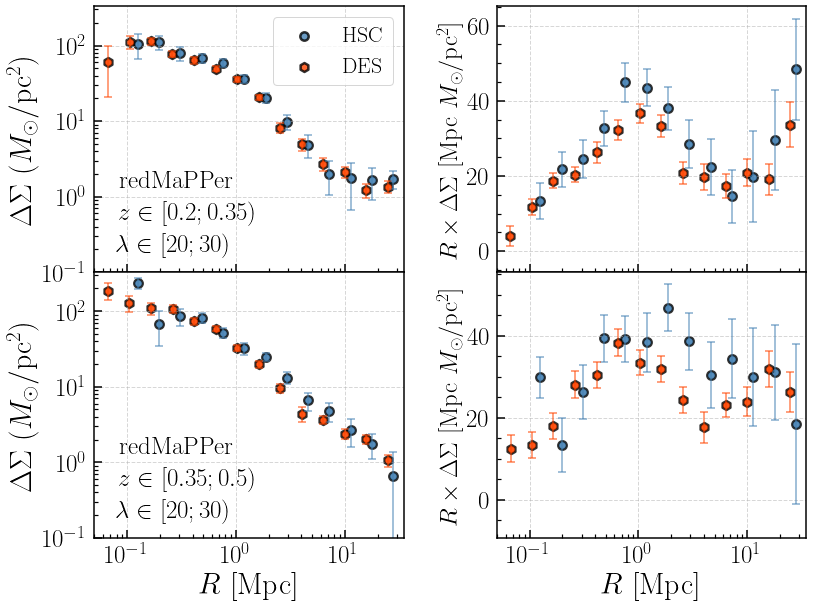

In [40]:
fig = plt.figure(figsize=(11.5, 9))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

# ---------------------------------------------------------------------- #
# 0.2 < z < 0.35
ax1 = fig.add_subplot(221)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3[0]['dsigma'], yerr=dsig_hsc_3[0]['dsig_err_jk'],
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_1['r_mpc'], des_1['dsigma'], yerr=des_1['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    des_1['r_mpc'] , des_1['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.05, 35)
_ = ax1.set_ylim(0.1, 329)

#ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.35)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [20; 30)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(222)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3.meta['r_mpc'] * dsig_hsc_3[0]['dsigma'], 
    yerr=(dsig_hsc_3.meta['r_mpc'] * dsig_hsc_3[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3.meta['r_mpc'] * dsig_hsc_3[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_1['r_mpc'], des_1['r_mpc'] * des_1['dsigma'], 
    yerr=(des_1['r_mpc'] * des_1['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_1['r_mpc'] , des_1['r_mpc'] * des_1['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.05, 35)
#_ = ax2.set_ylim(11, 62)

#_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

# ---------------------------------------------------------------------- #
# 0.35 < z < 0.5
ax3 = fig.add_subplot(223)
ax3.set_xscale("log", nonpositive='clip')
ax3.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax3.errorbar(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3[1]['dsigma'], yerr=dsig_hsc_3[1]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax3.scatter(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax3.errorbar(
    des_2['r_mpc'], des_2['dsigma'], yerr=des_2['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax3.scatter(
    des_2['r_mpc'] , des_2['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

#ax3.legend(loc='best', fontsize=22)

_ = ax3.set_xlim(0.05, 35)
_ = ax3.set_ylim(0.1, 329)

ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax3.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax3.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.08, 0.20, r'$z\in [0.35; 0.5)$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.07, 0.08, r'$\lambda \in [20; 30)$', transform=ax3.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax4 = fig.add_subplot(224)
ax4.set_xscale("log", nonpositive='clip')

# HSC profile
ax4.errorbar(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3.meta['r_mpc'] * dsig_hsc_3[1]['dsigma'], 
    yerr=(dsig_hsc_3.meta['r_mpc'] * dsig_hsc_3[1]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    dsig_hsc_3.meta['r_mpc'], dsig_hsc_3.meta['r_mpc'] * dsig_hsc_3[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax4.errorbar(
    des_2['r_mpc'], des_2['r_mpc'] * des_2['dsigma'], 
    yerr=(des_2['r_mpc'] * des_2['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    des_2['r_mpc'] , des_2['r_mpc'] * des_2['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax4.set_xlim(0.05, 35)
#_ = ax4.set_ylim(11, 62)

_ = ax4.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax4.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

##### 30 < lambda < 45

In [41]:
des_1 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l4_z0_profile.dat'), format='ascii')
des_2 = Table.read(os.path.join(des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_l4_z1_profile.dat'), format='ascii')

In [42]:
mask_1 = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.35) &
    (redm_hsc['lambda'] >= 30) & (redm_hsc['lambda'] < 45)
)

mask_2 = (
    (redm_hsc['z'] >= 0.35) & (redm_hsc['z'] <= 0.5) &
    (redm_hsc['lambda'] >= 30) & (redm_hsc['lambda'] < 45)
)

print(mask_1.sum(), mask_2.sum())

dsig_hsc_4 = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_1, mask_2], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

19 32
There are 19 objects in sample 1
There are 32 objects in sample 2


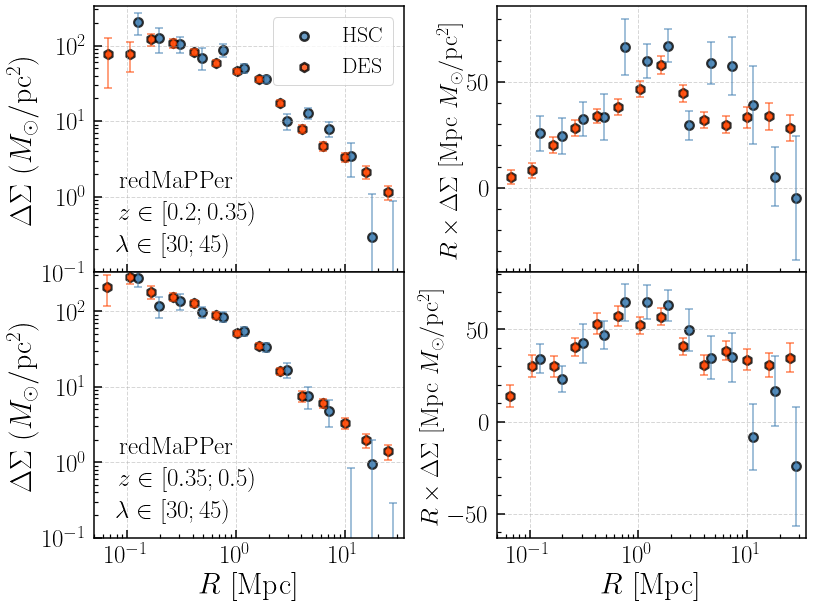

In [43]:
fig = plt.figure(figsize=(11.5, 9))
fig.subplots_adjust(left=0.13, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.3, hspace=0.0)

# ---------------------------------------------------------------------- #
# 0.2 < z < 0.35
ax1 = fig.add_subplot(221)
ax1.set_xscale("log", nonpositive='clip')
ax1.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax1.errorbar(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4[0]['dsigma'], yerr=dsig_hsc_4[0]['dsig_err_jk'],
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax1.errorbar(
    des_1['r_mpc'], des_1['dsigma'], yerr=des_1['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax1.scatter(
    des_1['r_mpc'] , des_1['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

ax1.legend(loc='best', fontsize=22)

_ = ax1.set_xlim(0.05, 35)
_ = ax1.set_ylim(0.1, 329)

#ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax1.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.08, 0.20, r'$z\in [0.2; 0.35)$', transform=ax1.transAxes, fontsize=25)
ax1.text(0.07, 0.08, r'$\lambda \in [30; 45)$', transform=ax1.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(222)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4.meta['r_mpc'] * dsig_hsc_4[0]['dsigma'], 
    yerr=(dsig_hsc_4.meta['r_mpc'] * dsig_hsc_4[0]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4.meta['r_mpc'] * dsig_hsc_4[0]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax2.errorbar(
    des_1['r_mpc'], des_1['r_mpc'] * des_1['dsigma'], 
    yerr=(des_1['r_mpc'] * des_1['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax2.scatter(
    des_1['r_mpc'] , des_1['r_mpc'] * des_1['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax2.set_xlim(0.05, 35)
#_ = ax2.set_ylim(11, 62)

#_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)

# ---------------------------------------------------------------------- #
# 0.35 < z < 0.5
ax3 = fig.add_subplot(223)
ax3.set_xscale("log", nonpositive='clip')
ax3.set_yscale("log", nonpositive='clip')

# ---- DeltaSigma ---- #
# HSC profile
ax3.errorbar(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4[1]['dsigma'], yerr=dsig_hsc_4[1]['dsig_err_jk'],
             ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
             label='__no_label__', fmt='o')
ax3.scatter(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax3.errorbar(
    des_2['r_mpc'], des_2['dsigma'], yerr=des_2['dsig_err'],
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax3.scatter(
    des_2['r_mpc'] , des_2['dsigma'], s=80, alpha=0.8, marker='h', 
    facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

#ax3.legend(loc='best', fontsize=22)

_ = ax3.set_xlim(0.05, 35)
_ = ax3.set_ylim(0.1, 329)

ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
ax3.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)

ax3.text(0.08, 0.32, r'$\rm redMaPPer$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.08, 0.20, r'$z\in [0.35; 0.5)$', transform=ax3.transAxes, fontsize=25)
ax3.text(0.07, 0.08, r'$\lambda \in [30; 45)$', transform=ax3.transAxes, fontsize=25)


# ---- R x DeltaSigma ---- #
ax4 = fig.add_subplot(224)
ax4.set_xscale("log", nonpositive='clip')

# HSC profile
ax4.errorbar(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4.meta['r_mpc'] * dsig_hsc_4[1]['dsigma'], 
    yerr=(dsig_hsc_4.meta['r_mpc'] * dsig_hsc_4[1]['dsig_err_jk']),
    ecolor='steelblue', color='steelblue', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    dsig_hsc_4.meta['r_mpc'], dsig_hsc_4.meta['r_mpc'] * dsig_hsc_4[1]['dsigma'], s=70, alpha=0.8, 
    facecolor='steelblue', edgecolor='k', label=r'$\rm HSC$', linewidth=2.5)

# DES Profile
ax4.errorbar(
    des_2['r_mpc'], des_2['r_mpc'] * des_2['dsigma'], 
    yerr=(des_2['r_mpc'] * des_2['dsig_err']),
    ecolor='orangered', color='orangered', alpha=0.5, capsize=4, capthick=2.0, elinewidth=2.0, 
    label='__no_label__', fmt='o')
ax4.scatter(
    des_2['r_mpc'] , des_2['r_mpc'] * des_2['dsigma'], s=80, alpha=0.8, 
    marker='h', facecolor='orangered', edgecolor='k', label=r'$\rm DES$', linewidth=2.5)

_ = ax4.set_xlim(0.05, 35)
#_ = ax4.set_ylim(11, 62)

_ = ax4.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax4.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=25)